In [18]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, Precision, Recall, TopKCategoricalAccuracy
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB4
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

In [19]:
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU')) 

TensorFlow version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:8', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:9', device_type='GPU')]


In [20]:
current_path = os.getcwd()
train_dir = current_path + '/ISIC2019Dataset/data/train/'
val_dir = current_path + '/ISIC2019Dataset/data/val/'
test_dir = current_path + '/ISIC2019Dataset/ISIC_2019_test_dir/'
training_directory_path = '/ISIC2019Dataset/ISIC_2019_Training_Input/'
training_metadata_path = '/ISIC2019Dataset/ISIC_2019_Training_Metadata.csv'
ground_truth_path = '/ISIC2019Dataset/ISIC_2019_Training_GroundTruth.csv'
test_directory_path = '/ISIC2019Dataset/ISIC_2019_Test_Input/'
test_metadata_path = '/ISIC2019Dataset/ISIC_2019_Test_Metadata.csv'

training_metadata_table = pd.read_csv(current_path + training_metadata_path)
test_metadata_table = pd.read_csv(current_path + test_metadata_path)
ground_truth_table = pd.read_csv(current_path + ground_truth_path)

In [4]:
training_metadata_table

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


LABELS

- MEL - Melanoma
- NV - Melanocytic nevus
- BCC - Basal cell carcinoma
- AK - Actinic keratosis
- BKL - Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF - Dermatofibroma
- VASC - Vascular lesion
- SCC - Squamous cell carcinoma
- UNK - None of the above

In [5]:
training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)
training_metadata_table.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
training_metadata_table.isnull().sum()

/tmp/ipykernel_536664/174194398.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)


image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64

In [6]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)
ground_truth_table.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [7]:

# for c in classes:
#     # folders inside train_dir
#     class_train_dir = os.path.join(data_dir, c)
#     if not os.path.exists(class_train_dir):
#         os.mkdir(class_train_dir)

#     # folders inside val_dir
#     class_val_dir = os.path.join(data_dir, c)
#     if not os.path.exists(class_val_dir):
#         os.mkdir(class_val_dir)

In [17]:
# ground_truth_table.set_index('image', inplace=True)
# folder = os.listdir(current_path + training_directory_path)
# image_list = list(ground_truth_table.index)

# for image in image_list:
    
#     fname = image + '.jpg'
#     label = ground_truth_table.loc[image,'label']
    
#     if fname in folder:
#         src = os.path.join(current_path + training_directory_path, fname)
#         dst = os.path.join(data_dir, label, fname)
#         shutil.copyfile(src, dst)

In [18]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Define dataset paths
# data_dir = '/home/fall2019/qnd5128/capstone/SkinLesionClassification/ISIC2019Dataset/ISIC_2019_data_dir'
# base_dir = '/home/fall2019/qnd5128/capstone/SkinLesionClassification/ISIC2019Dataset/data'
# train_dir = os.path.join(base_dir, 'train')
# val_dir = os.path.join(base_dir, 'val')

# # Print paths for confirmation
# print("Base directory for split data:", base_dir)
# print("Original data directory:", data_dir)

# # Create directories for training and validation
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Get all classes (folders) in the original dataset directory
# classes = os.listdir(data_dir)

# # Split the data and organize into folders
# for class_name in classes:
#     # Create class-specific directories in train and validation folders
#     os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#     os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    
#     # List all images in each class folder
#     images = os.listdir(os.path.join(data_dir, class_name))
#     images = [os.path.join(data_dir, class_name, img) for img in images]
    
#     # Split images into train and validation sets (e.g., 85% train, 15% validation)
#     train_images, val_images = train_test_split(images, test_size=0.15, random_state=42)
    
#     # Move images to the train directory
#     for img in train_images:
#         shutil.copy(img, os.path.join(train_dir, class_name))
    
#     # Move images to the validation directory
#     for img in val_images:
#         shutil.copy(img, os.path.join(val_dir, class_name))

# print("Data split into training and validation directories successfully.")


## Train Test Split & Data Augmentation

In [21]:
target_size = (224,224)
image_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_batches = image_gen.flow_from_directory(train_dir,
                                              target_size=target_size,
                                              color_mode='rgb',
                                              batch_size=20,
                                              class_mode='categorical',
                                              shuffle=True)

val_batches = image_gen.flow_from_directory(val_dir,
                                            target_size=target_size,
                                            color_mode='rgb',
                                            batch_size=20,
                                            class_mode='categorical',
                                            shuffle=False)

print(train_batches.class_indices)

Found 21527 images belonging to 8 classes.
Found 3804 images belonging to 8 classes.
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


## Transfer Learning using EfficientNetB4 Model

In [9]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:  
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


W0000 00:00:1731501969.181166  536664 gpu_device.cc:2277] Unable to enable peer access between device ordinals 0 and 9, status: INTERNAL: failed to enable peer access from 0x55771eb92050 to 0x557723e83240: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731501969.205387  536664 gpu_device.cc:2277] Unable to enable peer access between device ordinals 1 and 9, status: INTERNAL: failed to enable peer access from 0x55771f4d57c0 to 0x557723e83240: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731501969.224232  536664 gpu_device.cc:2277] Unable to enable peer access between device ordinals 2 and 9, status: INTERNAL: failed to enable peer access from 0x55771fdea9a0 to 0x557723e83240: INTERNAL: CUDA error: : CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
W0000 00:00:1731501969.242816  536664 gpu_device.cc:2277] Unable to enable peer access between device ordinals 3 and 9, status: IN

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 18,134,887 (69.18 MB)

 Trainable params: 7,341,248 (28.00 MB)

 Non-trainable params: 10,793,639 (41.17 MB)

### Calculate Class Weights

In [10]:
label_to_index = train_batches.class_indices  

index_to_label = {v: k for k, v in label_to_index.items()}
ground_truth_table['label_index'] = ground_truth_table['label'].map(label_to_index)

classes = np.unique(ground_truth_table['label_index'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=ground_truth_table['label_index']
)

class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 3.652104959630911,
 1: 0.9528663857959675,
 2: 1.2066977896341464,
 3: 13.248430962343097,
 4: 0.7002156125608138,
 5: 0.24593203883495146,
 6: 5.041998407643312,
 7: 12.515316205533598}

### Training Model 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

# Function to compute sample weights
def compute_sample_weights(labels, class_weights):
    sample_weights = np.array([class_weights[np.argmax(label)] for label in labels])
    return sample_weights

def generator_with_sample_weights(generator, class_weights):
    while True:
        x, y = next(generator)
        sample_weights = compute_sample_weights(y, class_weights)
        yield x, y, sample_weights


train_batches_with_weights = generator_with_sample_weights(train_batches, class_weights_dict)
valid_batches_with_weights = generator_with_sample_weights(val_batches, class_weights_dict)


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy, 
                       Precision(name='precision'), 
                       Recall(name='recall'), 
                       TopKCategoricalAccuracy(k=3, name='top_3_accuracy')])

checkpoint = ModelCheckpoint('efficientnetb4_2_checkpoint.keras', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, verbose=1, mode='max', min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

callbacks_list = [checkpoint, reduce_lr, early_stopping]

history = model.fit(
    train_batches_with_weights,
    validation_data=valid_batches_with_weights,
    steps_per_epoch=len(train_batches),
    validation_steps=len(val_batches),
    epochs=15,
    callbacks=callbacks_list
)

# Save the final model
model.save('efficientnetb4_2_full_model_after_training.keras')

Epoch 1/15


I0000 00:00:1731502024.658573  536966 service.cc:148] XLA service 0x7f00300a9130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731502024.658633  536966 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731502024.658641  536966 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731502024.658646  536966 service.cc:156]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1731502024.658650  536966 service.cc:156]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5
I0000 00:00:1731502024.658655  536966 service.cc:156]   StreamExecutor device (4): Tesla T4, Compute Capability 7.5
I0000 00:00:1731502024.658659  536966 service.cc:156]   StreamExecutor device (5): Tesla T4, Compute Capability 7.5
I0000 00:00:1731502024.658663  536966 service.cc:156]   StreamExecutor device (6): Tesla T4, Compute Capability 7.5
I0000 00:00:1731502

   1/1077 ━━━━━━━━━━━━━━━━━━━━ 14:16:32 48s/step - categorical_accuracy: 0.0500 - loss: 6.2750 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_3_accuracy: 0.3000

I0000 00:00:1731502051.794880  536966 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1077/1077 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - categorical_accuracy: 0.3221 - loss: 5.6595 - precision: 0.6206 - recall: 0.0926 - top_3_accuracy: 0.6303
Epoch 1: val_categorical_accuracy improved from -inf to 0.50789, saving model to efficientnetb4_2_checkpoint.keras
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 534s 452ms/step - categorical_accuracy: 0.3222 - loss: 5.6588 - precision: 0.6206 - recall: 0.0927 - top_3_accuracy: 0.6304 - val_categorical_accuracy: 0.5079 - val_loss: 3.7508 - val_precision: 0.7188 - val_recall: 0.2815 - val_top_3_accuracy: 0.8197 - learning_rate: 1.0000e-04
Epoch 2/15
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - categorical_accuracy: 0.5299 - loss: 3.4256 - precision: 0.6897 - recall: 0.3244 - top_3_accuracy: 0.8510
Epoch 2: val_categorical_accuracy improved from 0.50789 to 0.56756, saving model to efficientnetb4_2_checkpoint.keras
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 445s 414ms/step - categorical_accuracy: 0.5299 - loss: 3.4254 - precision: 0.6897 - recall: 0.3244 - top_3_a

In [ ]:
# Extract metrics from history for Resnet50
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
# train_f1 = history.history['f1_m']
# val_f1 = history.history['val_f1_m']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot and save the metrics
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(current_path, 'efficientnetb4_2_training_validation_loss.png'))

# Plot Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'efficientnetb4_2_training_validation_accuracy.png'))

# Plot Recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'r-', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig(os.path.join(current_path, 'efficientnetb4_2_training_validation_recall.png'))

# Plot Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, 'r-', label='Training Precision')
plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
plt.title('Training and Validation Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig(os.path.join(current_path, 'efficientnetb4_2_training_validation_precision.png'))

# Plot F1 Score
# plt.subplot(2, 3, 5)
# plt.plot(epochs, train_f1, 'r-', label='Training F1 Score')
# plt.plot(epochs, val_f1, 'b-', label='Validation F1 Score')
# plt.title('Training and Validation F1 Score per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.savefig(os.path.join(current_path, 'resnet50_training_validation_f1_score.png'))

# Plot Top 3 Accuracy
plt.subplot(2, 3, 6)
plt.plot(epochs, train_top3_acc, 'r-', label='Training Top 3 Accuracy')
plt.plot(epochs, val_top3_acc, 'b-', label='Validation Top 3 Accuracy')
plt.title('Training and validation Top 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 3 Accuracy')
plt.legend()
plt.savefig(os.path.join(current_path, 'efficientnetb4_2_training_validation_top3_acc.png'))

plt.tight_layout()
plt.savefig(os.path.join(current_path, 'efficientnetb4_2_all_metrics_plots.png'))
plt.show()


In [ ]:
model.evaluate(val_batches)

132/191 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - categorical_accuracy: 0.6771 - loss: 0.9663 - precision: 0.7306 - recall: 0.6147 - top_3_accuracy: 0.9454

In [ ]:
predictions = model.predict(val_batches, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = val_batches.classes

In [25]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)
print(classification_report(val_batches.classes, predictions, zero_division=0))

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

Confusion matrix, without normalization
[[  98   16    9    1    2    1    4    0]
 [  43  368   18   14   13   15   23    5]
 [  44   28  244    2   28   29   14    5]
 [   1    3    0   29    1    2    0    0]
 [  47   40   51    8  408  111   14    0]
 [  30   85  110   22  217 1422   26   20]
 [  17   17    6    4    1    2   48    0]
 [   1    1    0    6    0    1    0   29]]


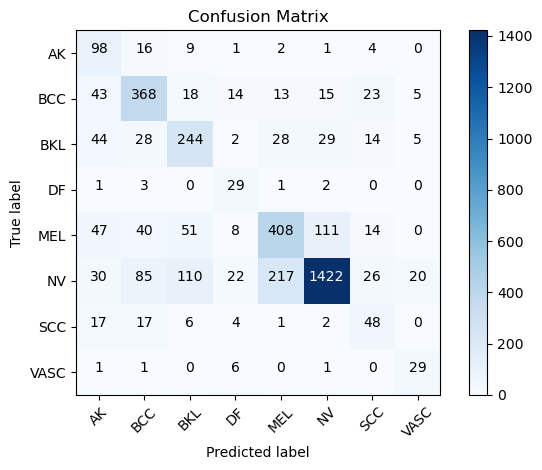

In [23]:
from sklearn import metrics
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

test_labels = val_batches.classes
cm_plot_labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

/home/fall2019/qnd5128/miniconda3/envs/capstone_env_/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 80s 381ms/step
Confusion Matrix:
[[  98   16    9    1    2    1    4    0]
 [  43  368   18   14   13   15   23    5]
 [  44   28  244    2   28   29   14    5]
 [   1    3    0   29    1    2    0    0]
 [  47   40   51    8  408  111   14    0]
 [  30   85  110   22  217 1422   26   20]
 [  17   17    6    4    1    2   48    0]
 [   1    1    0    6    0    1    0   29]]


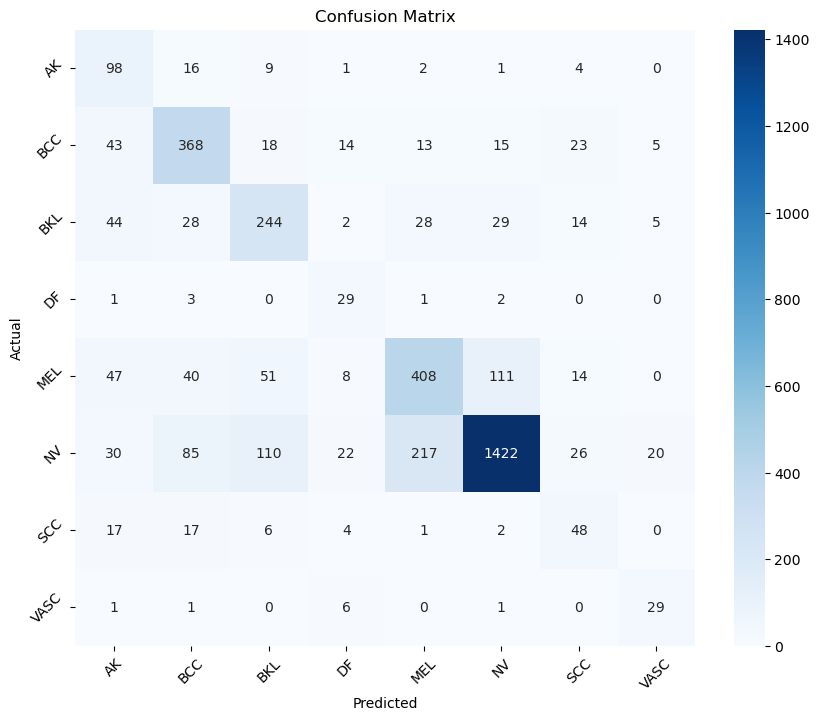

Classification Report:
              precision    recall  f1-score   support

          AK       0.35      0.75      0.48       131
         BCC       0.66      0.74      0.70       499
         BKL       0.56      0.62      0.59       394
          DF       0.34      0.81      0.48        36
         MEL       0.61      0.60      0.60       679
          NV       0.90      0.74      0.81      1932
         SCC       0.37      0.51      0.43        95
        VASC       0.49      0.76      0.60        38

    accuracy                           0.70      3804
   macro avg       0.53      0.69      0.58      3804
weighted avg       0.74      0.70      0.71      3804



In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# 1. Load the Best Model
best_model = load_model('efficientnetb4_2_full_model_after_training.keras')

# 2. Predict on Validation Data
val_steps = len(val_batches)
predictions = best_model.predict(val_batches, steps=len(val_batches), verbose=1)
y_pred = np.argmax(predictions, axis=1)

# 3. Retrieve True Labels
y_true = val_batches.classes

# 4. Map Class Indices to Class Names
class_labels = list(val_batches.class_indices.keys())

# 5. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 6. Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# 7. Generate Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)



In [24]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import confusion_matrix

sensitivity, specificity, _ = sensitivity_specificity_support(y_true, y_pred, average=None)

# Print specificity for each class
for idx, class_name in enumerate(class_labels):
    print(f"Sensitivity (Recall) for class {class_name}: {sensitivity[idx]:.4f}")
    print(f"Specificity for class {class_name}: {specificity[idx]:.4f}")

# 9. Calculate Weighted Average Specificity
# Get class support (number of instances in each class)
_, _, supports = sensitivity_specificity_support(y_true, y_pred, average=None)
weighted_specificity = np.sum(specificity * supports) / np.sum(supports)

print("Weighted Average Specificity:", weighted_specificity)

weighted_sensitivity = np.sum(sensitivity * supports) / np.sum(supports)
print("Weighted Average Sensitivity:", weighted_sensitivity)

Sensitivity (Recall) for class AK: 0.7481
Specificity for class AK: 0.9502
Sensitivity (Recall) for class BCC: 0.7375
Specificity for class BCC: 0.9425
Sensitivity (Recall) for class BKL: 0.6193
Specificity for class BKL: 0.9431
Sensitivity (Recall) for class DF: 0.8056
Specificity for class DF: 0.9849
Sensitivity (Recall) for class MEL: 0.6009
Specificity for class MEL: 0.9162
Sensitivity (Recall) for class NV: 0.7360
Specificity for class NV: 0.9140
Sensitivity (Recall) for class SCC: 0.5053
Specificity for class SCC: 0.9782
Sensitivity (Recall) for class VASC: 0.7632
Specificity for class VASC: 0.9920
Weighted Average Specificity: 0.9254367774051071
Weighted Average Sensitivity: 0.695583596214511
